<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
    <h1>Team GAIASAVERS</h1>
    <h3>Alban Petit, Wafa Bouzouita,Timothée Babinet, Maxime Chor, Eric Wang, Sebastien Warichet</h3>
    <h2>Plankton classification challenge</h2>

<br>This code was tested with <br>
Python 3.7 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
     <br>
       
According to [NRMA15], a link has been found between the quality of water and the presence of plankton in said water. As water quality increases, the abundance and diversity of plankton does as well. The aim of our project is to build a plankton classifier to assess water quality.

We use for this problem the Bering Sea dataset, an in situ plankton dataset published in May 2019 by Kaichang Cheng [Che19]. This datset contains 7 classes with an even spread.

        
References and credits: 
- [NRMA15] A. Nair, J.K. Reshma, A. Mathew, and A. Ashok. Effect of water quality on phytoplankton abundance in selected ponds of nedumangad block panchayat, kerala. Emer Life Sci Res, 2015.
- [Che19] K. Cheng. Bering sea dataset. https://doi.org/10.6084/m9.figshare.8146283.v3, 2019.
 <br>
</div>

<img src="images/sample.png" alt="Drawing"/>
To see more images for each class, see the "images" folder.

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sklearn

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [3]:
#data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_dir = './public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*

plankton_feat.name    plankton_test.data       plankton_valid.data
plankton_label.name   plankton_train.data
plankton_public.info  plankton_train.solution


<h3>Two "feature representation"</h3>

<p>
1.
All of the images are in various shades of gray. As such, we can represent every image by a vector of 90000 (300x300) features where each feature is a float value between 0 and 255 representing the brightness of a pixel (0 being a black pixel and 255 a white one). It is also possible to reduce the size of the images to reduce the number of features as seen in figure 3 where we reduced the size to 100x100 pixels.
</p>

<tr>
    <td> <img src="images/gray.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="images/binarized.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


<p>
2. At first we will have four types of "features". Two "features" are applied on the binarized images.
    <ul>
        <li>The first is a sum of black pixels, per line and per column.
This gives us 2 vectors of size 100. These "features" are representative among others of the shape of the plankton.
For round seeders the ratio between rows and columns near the center of the image should be close.
For longer plankton the ratio will be either low or high, depending on plankton position.
        </li>
        <li>The second is the average of the pixels.
            This gives us information on the size of the plankton.
        </li>
        <li>The third feature is the variance and is applied to non-binarized images.</li>
        <li>The last feature is the length of the contour of the plankton. It is obtained by applying a sobel filter on the image. This filter will put black pixels on the contours and white ones everywhere else. We can then just compute the amount of black pixels.
    </ul>
</p>

For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [4]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading ./public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


This shows the distribution of labels in the training set

In [5]:
data['target'].value_counts()

euphausiids     1536
limacina        1536
fish_larvae     1536
other           1536
medusae         1536
chaetognatha    1536
copepoda        1536
Name: target, dtype: int64

<div style="background:#f36864">

<h1>
On a besoin d'extraire pour chaque label/ target le mean/ variance/ outline_lenght correspondant puique c'est en analysant ça, qu'on pourra observer des "patterns" entre les différents target

</div>

<div style="background:#f36864">

<h1>
On sais qu'il faut pas écrire la fonction comme cela surtout pour l'optimisation, on devrait utiliser les méthodes/fonctions de pandas. Mais pour l'instant c'est juste pour voir si les données en sorties sont intéressants puis si les données sont pertinant on réécrirai la fonction comme voulu

</div>

In [6]:
def valueEnFonctionTarget(value, target):
    import numpy as np
    valeur=0
    if value== 'mean':
        valeur=200
    if value== 'variance':
        valeur=201
    if value== 'outline_length':
        valeur=202
    
    tab_other=[]
    for i in thing:
        if(i[203]==target):
            tab_other.append(i)
    
    mean_other=[]
    for i in tab_other:
        mean_other.append(i[valeur])
    tab= np.linspace(1, len(mean_other), len(mean_other))


    fig, ax = plt.subplots()
    ax.plot(tab, mean_other)
    plt.title(value +' pour les '+target)
    
    

/home/george/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


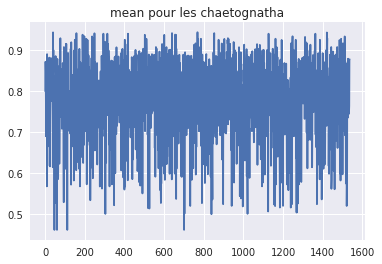

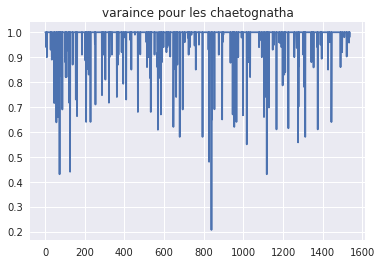

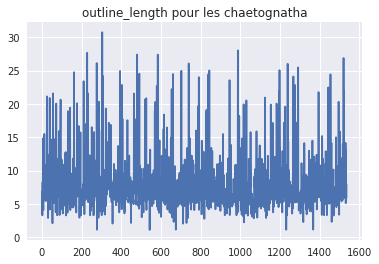

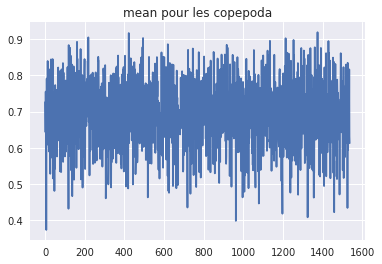

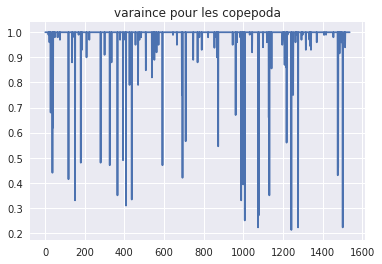

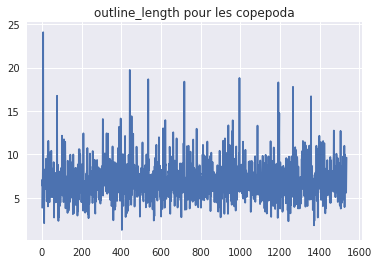

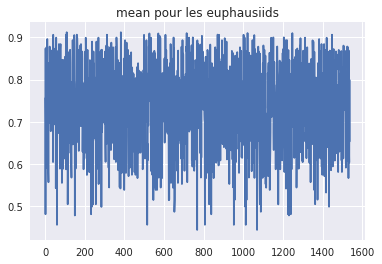

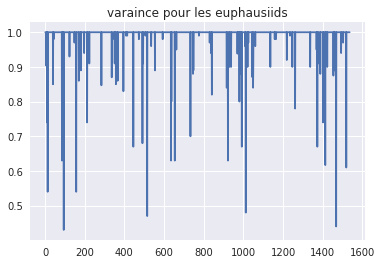

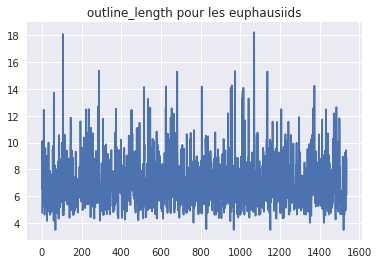

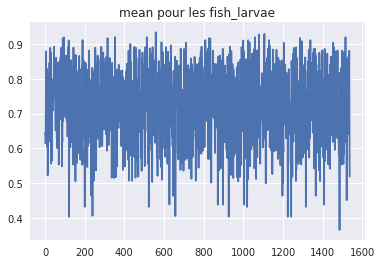

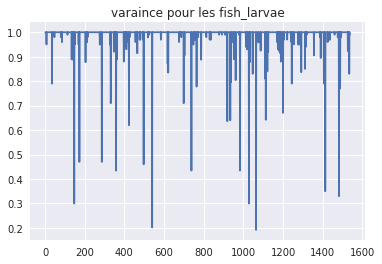

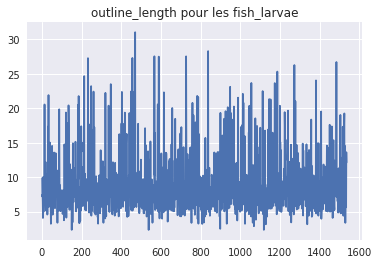

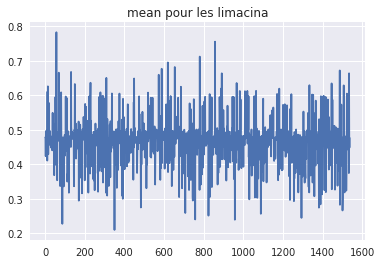

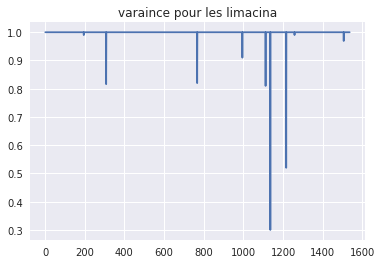

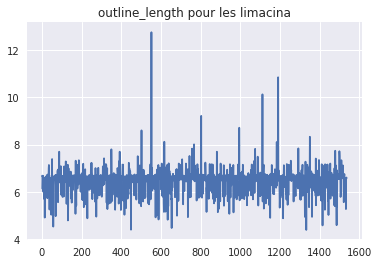

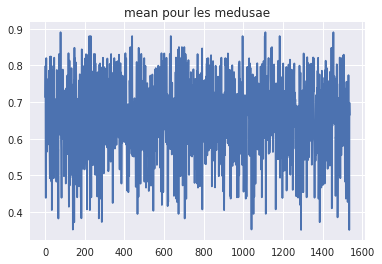

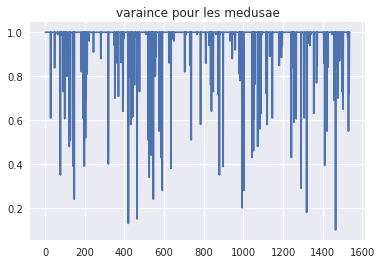

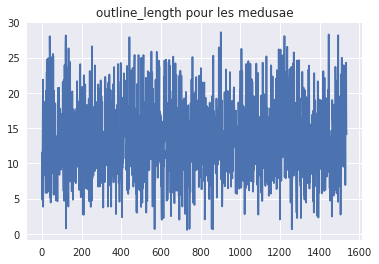

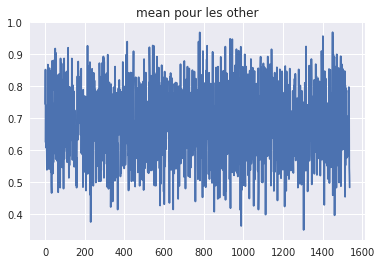

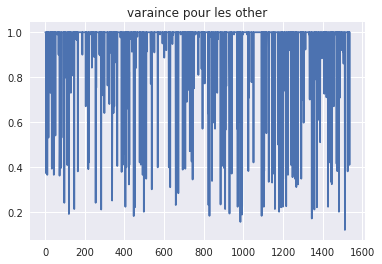

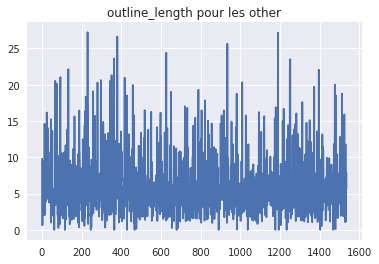

In [7]:
thing= data.values
values=['mean', 'varaince', 'outline_length']
targets=['chaetognatha', 'copepoda', 'euphausiids', 'fish_larvae', 'limacina', 'medusae', 'other' ]
for target in targets:
    for value in values:
        valueEnFonctionTarget(value, target)

<div style="background:#f36864">

<h1>
Il me semble au premier regard que les données en sorti ne sont pas vraiment intéressant, donc on ne réécrirai pas la fonction, néanmoins je laisse la fonction ici

</div>

In [8]:
data.head()

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length,target
0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.83871,0.83871,0.827957,0.817204,0.795699,0.774194,0.744560,0.062088,9.82,other
1,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,0.852347,0.021939,0.64,other
2,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.82000,0.90000,1.000000,1.000000,1.000000,1.000000,0.478031,0.130620,6.68,limacina
3,1.0,1.0,0.99,0.96,0.94,0.94,0.92,0.92,0.92,0.93,...,0.96000,0.99000,1.000000,1.000000,1.000000,1.000000,0.799294,0.037921,6.86,chaetognatha
4,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00000,0.99000,0.990000,0.990000,1.000000,1.000000,0.713423,0.065195,11.56,medusae


Some statistics about the features.

In [9]:
data.describe() 

,sum_axis_0_0,sum_axis_0_1,sum_axis_0_2,sum_axis_0_3,sum_axis_0_4,sum_axis_0_5,sum_axis_0_6,sum_axis_0_7,sum_axis_0_8,sum_axis_0_9,...,sum_axis_1_93,sum_axis_1_94,sum_axis_1_95,sum_axis_1_96,sum_axis_1_97,sum_axis_1_98,sum_axis_1_99,mean,variance,outline_length
count,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,...,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000,10752.000000
mean,0.979279,0.977036,0.972997,0.965795,0.956058,0.946609,0.938161,0.930047,0.922546,0.914766,...,0.936903,0.943581,0.951833,0.961342,0.966297,0.970557,0.971949,0.677502,0.074303,8.117898
std,0.096922,0.098681,0.099546,0.102380,0.106950,0.113165,0.119380,0.126461,0.132001,0.138568,...,0.118902,0.114981,0.110555,0.106497,0.105424,0.104636,0.105878,0.133997,0.033898,4.244094
min,0.100000,0.050000,0.070000,0.030000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.040000,0.209394,0.001928,0.000000
25%,1.000000,1.000000,1.000000,0.990000,0.960000,0.940000,0.930000,0.916667,0.900000,0.880000,...,0.920000,0.940000,0.950000,0.980000,1.000000,1.000000,1.000000,0.582888,0.049183,5.740000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.694925,0.068188,6.720000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.782364,0.094579,9.102500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969234,0.214556,31.030000


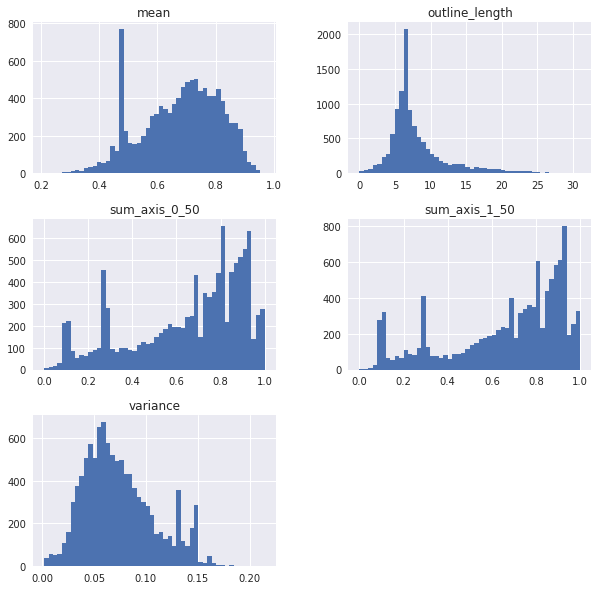

In [10]:
data[['sum_axis_0_50','sum_axis_1_50','mean','variance', 'outline_length']].hist(figsize=(10, 10), bins=50, layout=(3, 2));

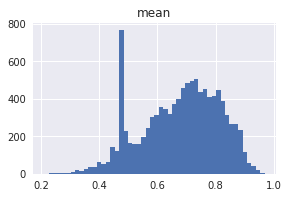

In [11]:
data[['mean']].hist(figsize=(10, 10), bins=50, layout=(3, 2));

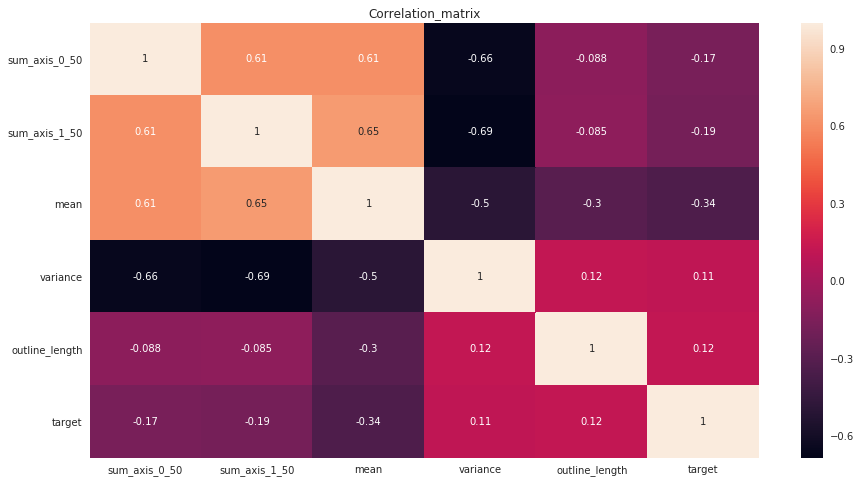

In [12]:
from sklearn import preprocessing
data_target = data.copy()
le = preprocessing.LabelEncoder()
data_target.target = le.fit_transform(data_target.target.values)
fig = plt.figure(figsize=(15,8))
sns.heatmap(data_target[['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length','target']].corr(), annot = True)
plt.title('Correlation_matrix')
plt.show()

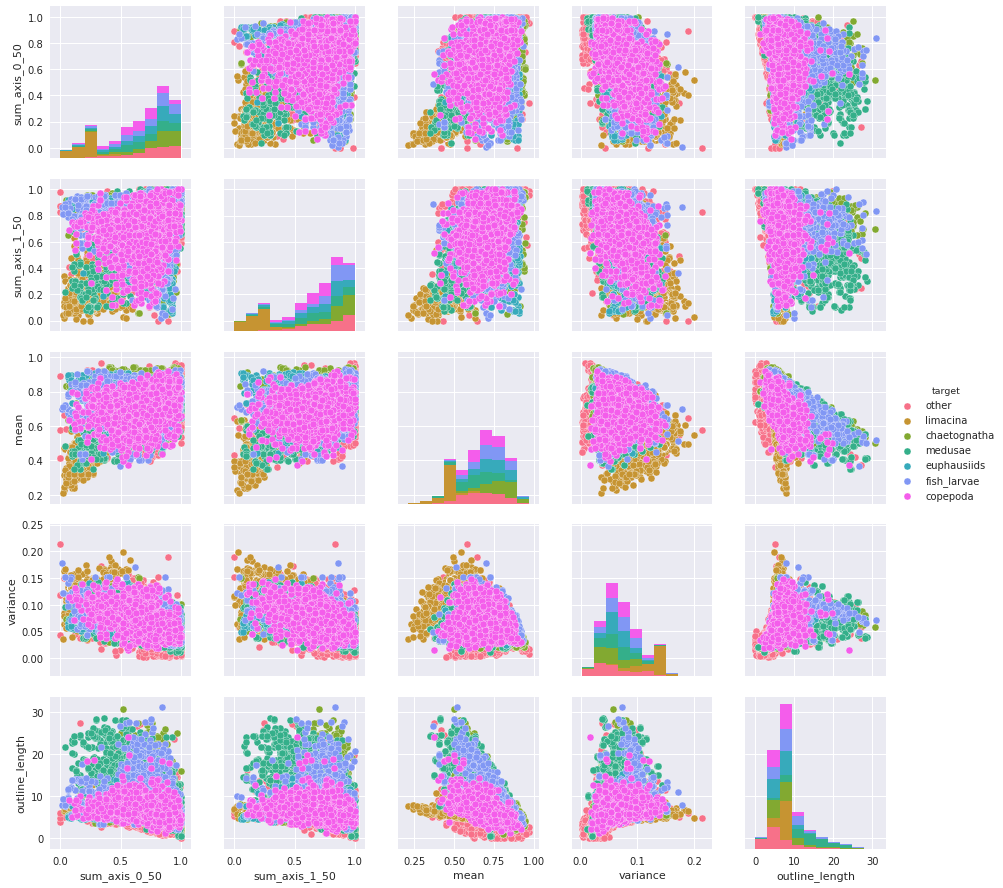

In [13]:
sns.pairplot(data,hue='target',vars=['sum_axis_0_50','sum_axis_1_50','mean','variance','outline_length'])
plt.show()

<div style="background:#93f189">

<br>Author: George Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>
<br>Description: Visualisation des clusters, pour observer des patterns: pour faire cela on utilise KMeans<br>

</div>

In [14]:
#On doit avoir 0<=x<=202 et 0<=y<=202
def kmeansThing(x, y):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.datasets import make_blobs
    
    test= data.copy()
    del test['target']
    tab= test.values
    names= list(test)

    plt.figure(figsize=(12, 12))

    y_pred = KMeans(n_clusters=7).fit_predict(tab)

    plt.subplot(221)
    plt.scatter(tab[:, x], tab[:, y], c=y_pred)
    plt.title(names[y]+ ' en fonctin de '+names[x])
    plt.xlabel("outline_length")
    plt.ylabel("mean")
    print(tab.shape)

    plt.show()

    

(10752, 203)


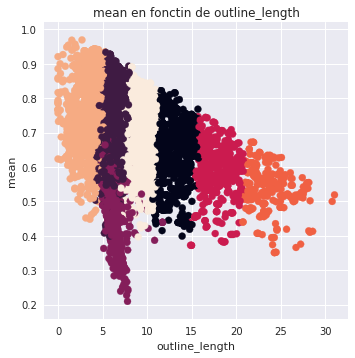

In [15]:
kmeansThing(202, 200)

In [16]:
#Test pour limacina
test= data.copy()
tab= test.values
tab[0][203]
somme=0
somme_total=0
for i in range(len(tab)):
    if(tab[i][202]>4.5 and tab[i][202]<10 and tab[i][200]<0.51 ):
        if(tab[i][203]=='limacina'):
            somme+=1
        #print(tab[i][203])
        somme_total+=1
print(somme/1536*100)
print(100-somme/somme_total*100)

90.234375
7.042253521126767


<div style="background:#93f189">

<h1>
Résultats très positifs => on peut déjà identifier 86% (1326/1536 *100%) des limacina, mais bien sûr il n'ya pas seulement les limacina dans cette intervalle, en total en compte au total 1417 plactons, donc il ya 94% de limacina dans entre intervalle, donc c'est quelque chose à prendre en compte

</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
</div>

In [17]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/george/Bureau/OCEAN/starting_kit/public_data/plankton_public.info
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [18]:
from data_io import write
from model import model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [19]:
# uncomment the desired model

# Decision tree model
from sklearn.tree import DecisionTreeClassifier
M = model(classifier=DecisionTreeClassifier(max_depth=10, max_features = 'sqrt',random_state=42))

trained_model_name = model_dir + data_name

# Uncomment the next line to re-load an already trained model
#M = model()
#M = M.load(trained_model_name)                  

TypeError: __init__() got an unexpected keyword argument 'classifier'

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [ ]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

if not(M.is_trained):
    M.fit(X_train, Y_train)
    print('training')

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])
len(Y_hat_train)

<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [ ]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

<div style="background:#93f189">

<br>Author: Luqman Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>

</div>

<div style="background:#93f189">

<h1>
Affichage de la surface de decision du classifer
Code de départ prit sur:https://scikit-learn.org/0.15/auto_examples/tree/plot_iris.html


</div>
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron


# Parameters
n_classes = 6
plot_colors = "brygwm"
plot_step = 0.002

# Load data


for pairidx, pair in enumerate([[1, 1], [1, 2], [1, 3],
                                [2, 1], [2, 3], [3, 1]]):
   
    # We only take the two corresponding features
    X1 = X_train[:,[199,200,201,202]]
    X = X1[:, pair]
    y = Y_train 
    # Shuffle
    idx = np.arange(X.shape[0])
    np.random.seed(13)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Standardize
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std
    # Train
    clf = Perceptron().fit(X, y)

    # Plot the decision boundary
    
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                          np.arange(y_min, y_max, plot_step))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    
    values=['sum_axis_1_99','mean' ,'variance' ,'outline_length']
    plt.xlabel(values[pair[0]])
    plt.ylabel(values[pair[1]])
    plt.axis("tight")
    targets=['chaetognatha', 'copepoda', 'euphausiids', 'fish_larvae', 'limacina', 'medusae', 'other' ]

     # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,label= targets[i],
                     cmap=plt.cm.Paired)
        
   

plt.suptitle("Graphe sur la   surface de décision du classifer  avec parametre  mean  ,variance ,outline_length ") 
plt.legend()
plt.show()


Le parametre en abscisse sur  la premiere ligne  est "mean"

<div style="background:#93f189">

<br>Author: George Team Ocean<br>
<br>Last revision Date: 04/04/2020<br>
<br>Description: The learning curve graphs shows the score (training score and cross-Validation score) of the model as a function of the size of the training set.<br>

</div>

<div style="background:#93f189">

<h1>
Affichage du Learning curve
Code de départ prit sur: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py


</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(True)
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(True)
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid(True)
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(6, 18))

title = "Learning Curves (En Fonction du model)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#Puique le model utiliser est DecisionTree
#A noter qu'il faut changer estimator en fonction du model choissi au-dessus
estimator = Perceptron()
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes, cv=cv, n_jobs=4)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(True)
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(True)
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid(True)
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(8, 24))

title = "Learning Curves (En Fonction du model)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

test= np.zeros(len(Y_train))

#Puique le model utiliser est DecisionTree
#A noter qu'il faut changer estimator en fonction du model choissi au-dessus
estimator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
plot_learning_curve(estimator, title, X_train, Y_train, axes=axes, cv=cv, n_jobs=4)
plt.show()

<div style="background:#93f189">

<h1>
Les courbes en sorti semblent cohérant avec le score pour les données de test au moins
</div>

<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

<div style="background:#FFFFAA">
The chosen metric is the balanced accuracy. It computes the proportion of elements correctly predicted for each class. It then returns the mean of these values. The advantage of this metric is that every class is given an equal weight. <br> In our case, since all the classes are perfectly balanced, it is equivalent to simply computing the accuracy score but it the case the test set is changed and is no longer balanced, the balanced accuracy will still work properly while the accuracy score will not.
</div>

In [ ]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [ ]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

You can add here other scores and result visualization.

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]
cm = confusion_matrix(Y_train, Y_hat_train)
cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.YlGn)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix",xlabel="Predicted label",ylabel="True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [ ]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [ ]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)